In [1]:
%%capture
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import integrate
from scipy import interpolate
import math
import sys
from scipy import signal
import pandas as pd
import tensorflow as tf
from numba import cuda
import numba
import os
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML
%run GRUSupportFns.ipynb
import mpld3
mpld3.enable_notebook()


In [2]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, Bidirectional
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras import backend as K 
from IPython.display import clear_output
from tensorflow.python.keras.initializers import RandomUniform
# tf.enable_eager_execution()

## Load DataStream and Ground Truth
As no reliable ground truth currently, using Kalman Filter results. Note: Ground truth must currently have the same timesteps as the input.

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

In [3]:
training_data, training_labels, test_data, test_labels,_ = load_train_test_data('data5.csv', 0.85)

Parsed File
Freq. of Acceleration 190.0300697928473
Freq. of Lin. Acceleration 49.00211454776328
Freq. of Gyroscope 52.67300802601869
Interpolated Samples
Loaded Ground Truth
Rotated Acceleration
Integrated Acceleration


In [4]:
norm_training_data, norm_training_labels, norm_test_data, norm_test_labels = scale_data(training_data, training_labels, 
                                                                                        test_data, test_labels)

In [ ]:
validation_data = (np.expand_dims(norm_test_data, axis=0), 
                   np.expand_dims(norm_test_labels, axis=0))

## Start Tensorflow Session 

Batches in the shape (Batch Size, Sequence Length, Input Dimension)

Hyper-parameters:
 - Batch Size
 - Sequence Length
 - Number of States in GRU layer


In [ ]:
sess = tf.InteractiveSession()
generator = batch_generator(batch_size=512, sequence_length=100)

In [ ]:
model = Sequential()
model.add(GRU(units=1024, return_sequences=True, input_shape=(None, x_dim,)))
model.add(GRU(units=1024, return_sequences=True))
model.add(Dense(y_dim, activation='linear'))

In [ ]:
# model = Sequential()
# model.add(Bidirectional(GRU(units=1024, return_sequences=True), merge_mode='ave',input_shape=(None, x_dim,)))
# model.add(Dense(y_dim, activation='linear'))         

In [ ]:
warmup_steps = 0

### Compile the Model

In [ ]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=custom_loss, optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 1024)        3164160   
_________________________________________________________________
gru_1 (GRU)                  (None, None, 1024)        6294528   
_________________________________________________________________
dense (Dense)                (None, None, 2)           2050      
Total params: 9,460,738
Trainable params: 9,460,738
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# path_checkpoint = '23_checkpoint.keras'
# callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
#                                       monitor='val_loss',
#                                       verbose=1,
#                                       save_weights_only=True,
#                                       save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)
# callback_tensorboard = TensorBoard(log_dir='./23_logs/',
#                                    histogram_freq=0,
#                                    write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-5,
                                       patience=0,
                                       verbose=1)       
plot_losses = PlotLosses()

callbacks = [callback_early_stopping,
#              callback_checkpoint,
#              callback_tensorboard,
             plot_losses,
             callback_reduce_lr]


## Train the Model
 - Choose the maximum amount of epochs
 - How many batches of the data per epoch

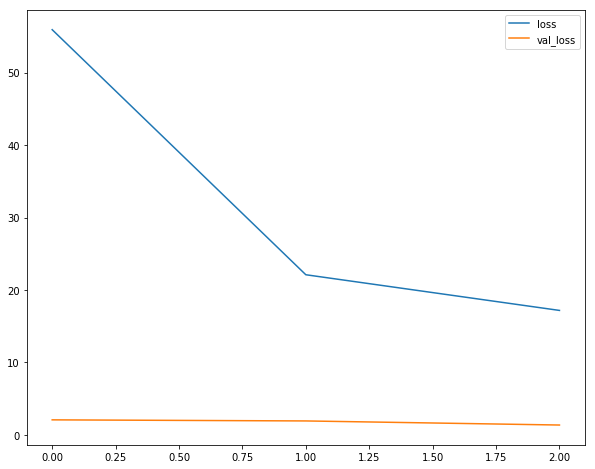

100/100 [==============================] - 68s 681ms/step - loss: 17.1816 - val_loss: 1.3680
Epoch 4/30
 99/100 [============================>.] - ETA: 0s - loss: 14.8089

In [ ]:
%%time
# model.fit(np.expand_dims(scaled_training_data, axis=0), np.expand_dims(scaled_training_labels, axis=0), epochs=10, 
#           batch_size=32, validation_data=validation_data, callbacks=callbacks)
model.fit_generator(generator=generator,
                    epochs=30,
                    steps_per_epoch=100, #Number of batches per epoch
                    validation_data=validation_data,
                    callbacks=callbacks)

## Evaluate Model on Test Data

In [ ]:
result = model.evaluate(x=np.expand_dims(norm_test_data, axis=0),
                        y=np.expand_dims(norm_test_labels, axis=0))
print("loss (test-set):", result)

In [ ]:
%matplotlib notebook
plot_comparison('data5.csv', train_percentage=0.0)

In [ ]:
plot_comparison('uni.csv', train_percentage=0.85)

## Reset Tensorflow Graph

In [ ]:
tf.reset_default_graph()
sess.close()